In [36]:
import ds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib.colors import ListedColormap
import math
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv("Cleaned_DF.csv")
df.drop("Unnamed: 0", axis = 1, inplace = True)

In [37]:
mask1 = (df['CryoSleep']==0)&(df['Age']>12.5)
features = ['Age','VIP','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Deck','Num','Side','route']
dz = df[mask1][features+["Transported"]]
dz.shape

(4447, 12)

Single Logisic Regrerssion gives 0.796 accuracy

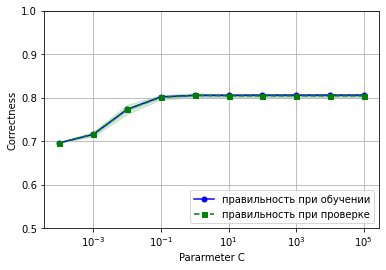

0.7955056179775281

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve

X_train, X_test, y_train, y_test = train_test_split(dz[features],dz["Transported"],test_size =0.2, stratify = dz["Transported"], random_state = 1)

pipe_lr = make_pipeline(StandardScaler(),LogisticRegression(penalty = 'l2',random_state = 1,solver = 'lbfgs', max_iter = 1000))

param_range = [0.0001,0.001, 0.01, 0.1, 1, 10, 100,1000, 10000, 100000]
train_scores, test_scores = validation_curve(estimator = pipe_lr, X = X_train, y = y_train, param_name = 'logisticregression__C',param_range = param_range, cv = 5, scoring="accuracy")

train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)

plt.plot(param_range, train_mean, color = 'blue', marker = 'o', markersize = 5, label = 'правильность при обучении')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha = 0.15, color='blue')

plt.plot(param_range, test_mean, color = 'green', linestyle = '--', marker = 's', markersize = 5, label = 'правильность при проверке')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha = 0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc = 'lower right')
plt.xlabel('Pararmeter C')
plt.ylabel('Correctness')
plt.ylim([0.5,1.0])
plt.show()

pipe = pipe_lr.fit(X_train,y_train)
pipe_lr.score(X_test,y_test)


In [39]:
from sklearn.metrics import confusion_matrix

y_pred = pipe_lr.predict(X_test)
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
print(confmat)

tp = confmat[0][0]
fn = confmat[0][1]
fp = confmat[1][0]
tn = confmat[1][1]

print(tp, fn)
print(fp, tn)

ERR = (fp+fn)/(tp+fp+fn+tn)
ACC = 1-ERR

FPR = fp/(fp+tn)
TPR = tp/(tp+fn)

PRE = tp/(tp+fp)
REC = tp/(fn+tp)

print('Точность (PRE) =%.3f'% PRE, 'Полнота (REC) = %.3f'% REC)
print('Точность по всем классам: %.3f'% ACC)

[[570  50]
 [132 138]]
570 50
132 138
Точность (PRE) =0.812 Полнота (REC) = 0.919
Точность по всем классам: 0.796


Let's see ROC curve and ROC score for Logistic Regression

Single LogisticRegression: ROC AUC=0.823


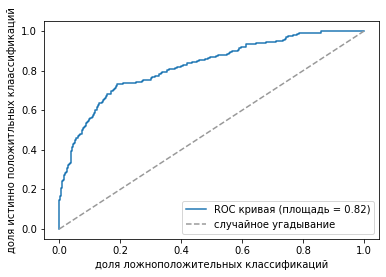

In [40]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from numpy import interp

probas = pipe_lr.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test,probas[:,1],pos_label = 1)

lr_auc = roc_auc_score(y_test, probas[:,1])
print('Single LogisticRegression: ROC AUC=%.3f' % (lr_auc))

roc_auc = auc(fpr,tpr)

plt.plot(fpr,tpr,label = 'ROC кривая (площадь = %0.2f)'% roc_auc)

plt.plot([0,1], [0,1], linestyle = '--', color = (0.6, 0.6, 0.6), label='случайное угадывание')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('доля ложноположительных классификаций')
plt.ylabel('доля истинно положитльных клаассификаций')
plt.legend(loc = "lower right")
plt.show()

Logistic Regression after LDA

LDA LogisticRegression: ROC AUC=0.823


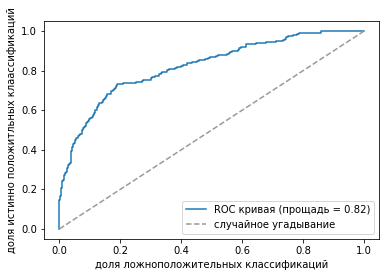

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.metrics import roc_curve, auc, roc_auc_score
from numpy import interp

X_train, X_test, y_train, y_test = train_test_split(dz[features],dz["Transported"],test_size =0.2, stratify = dz["Transported"], random_state = 1)

pipe_lda = make_pipeline(StandardScaler(),ds.LDA(plot = False),LogisticRegression(penalty = 'l2',random_state = 1,solver = 'lbfgs', max_iter = 1000))

pipe_lda = pipe_lda.fit(X_train, y_train)

probas = pipe.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test,probas[:,1],pos_label = 1)

lr_auc = roc_auc_score(y_test, probas[:,1])
print('LDA LogisticRegression: ROC AUC=%.3f' % (lr_auc))

roc_auc = auc(fpr,tpr)

plt.plot(fpr,tpr,label = 'ROC кривая (прощадь = %0.2f)'% roc_auc)

plt.plot([0,1], [0,1], linestyle = '--', color = (0.6, 0.6, 0.6), label='случайное угадывание')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('доля ложноположительных классификаций')
plt.ylabel('доля истинно положитльных клаассификаций')
plt.legend(loc = "lower right")
plt.show()


In [42]:
y_pred = pipe_lda.predict(X_test)
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
print(confmat)

[[566  54]
 [138 132]]


In [43]:
pipe_lda.score(X_test,y_test)

0.7842696629213484

Let's try AdaBoosting

In [44]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

tree = DecisionTreeClassifier(criterion='entropy',random_state = 1, max_depth = 1)
#ada = AdaBoostClassifier(base_estimator=tree, n_estimators = 500, learning_rate = 0.1, random_state = 1)
tree = tree.fit(X_train,y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test,y_test_pred)
print('Меры правильности дерева принятия решений при обучнеии/испытании %.3f/%.3f'%(tree_train,tree_test))


Меры правильности дерева принятия решений при обучнеии/испытании 0.702/0.707


In [45]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

ada = AdaBoostClassifier(base_estimator=tree, n_estimators = 500, learning_rate = 0.1, random_state = 1)

ada = ada.fit(X_train,y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train,y_train_pred)
ada_test = accuracy_score(y_test,y_test_pred)
print('Меры правильлности AdaBoost при обучнеии/испытании %.3f/%.3f'%(ada_train,ada_test))

Меры правильлности AdaBoost при обучнеии/испытании 0.823/0.802


AdaBoost: ROC AUC=0.835


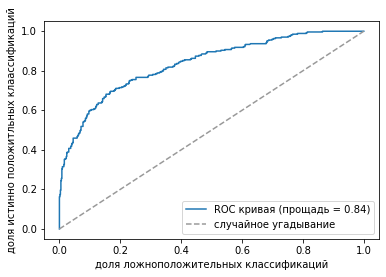

In [46]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from numpy import interp

probas = ada.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test,probas[:,1],pos_label = 1)

lr_auc = roc_auc_score(y_test, probas[:,1])
print('AdaBoost: ROC AUC=%.3f' % (lr_auc))

roc_auc = auc(fpr,tpr)

plt.plot(fpr,tpr,label = 'ROC кривая (прощадь = %0.2f)'% roc_auc)

plt.plot([0,1], [0,1], linestyle = '--', color = (0.6, 0.6, 0.6), label='случайное угадывание')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('доля ложноположительных классификаций')
plt.ylabel('доля истинно положитльных клаассификаций')
plt.legend(loc = "lower right")
plt.show()

Let's try Stacking with LR

Stacking LogisticRegression: ROC AUC=0.842


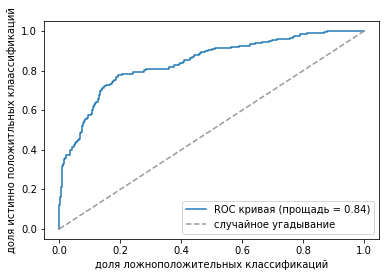

[[570  50]
 [132 138]]


0.8033707865168539

In [47]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from numpy import interp

pipe_lr = make_pipeline(StandardScaler(),LogisticRegression(penalty = 'l2',random_state = 1,solver = 'lbfgs', max_iter = 1000))
pipe_tree = make_pipeline(StandardScaler(),DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=1))
pipe_ada = make_pipeline(StandardScaler(),ada)
pipe_knn = make_pipeline(StandardScaler(),KNeighborsClassifier(n_neighbors =3, p=1,weights ='uniform'))

estimators = [
    ('Logistic Regression on full space', pipe_lr),
    #('Logistic Regression on 1-D space', pipe_lda),                       
    ('Tree on full space', pipe_tree),
    ('AdaBoost on full space', pipe_ada),
    ('KNN on full space', pipe_knn)
]

final_estimator = LogisticRegression(penalty = 'l2',random_state = 1,solver = 'lbfgs', max_iter = 1000, C=10)#

pipe_st = StackingClassifier(estimators=estimators, final_estimator = final_estimator,passthrough = False)

pipe_st = pipe_st.fit(X_train,y_train)
probas = pipe_st.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test,probas[:,1],pos_label = 1)

lr_auc = roc_auc_score(y_test, probas[:,1])
print('Stacking LogisticRegression: ROC AUC=%.3f' % (lr_auc))

roc_auc = auc(fpr,tpr)

plt.plot(fpr,tpr,label = 'ROC кривая (прощадь = %0.2f)'% roc_auc)

plt.plot([0,1], [0,1], linestyle = '--', color = (0.6, 0.6, 0.6), label='случайное угадывание')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('доля ложноположительных классификаций')
plt.ylabel('доля истинно положитльных клаассификаций')
plt.legend(loc = "lower right")
plt.show()

y_pred = pipe.predict(X_test)
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
print(confmat)

pipe_st.score(X_test,y_test)

Let's try majority vote

MJVC: ROC AUC=0.840


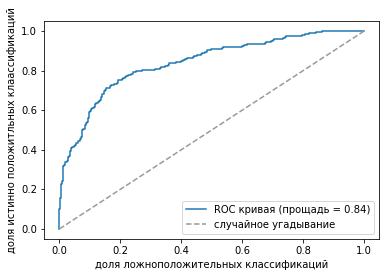

[[573  47]
 [139 131]]


0.7910112359550562

In [48]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from numpy import interp
import mjvc

#pipe = make_pipeline(StandardScaler(),LogisticRegression(penalty = 'l2',random_state = 1,solver = 'lbfgs', max_iter = 1000, C=100.0))
#pipe = make_pipeline(DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=1))

pipe_lr = make_pipeline(StandardScaler(),LogisticRegression(penalty = 'l2',random_state = 1,solver = 'lbfgs', max_iter = 1000))
pipe_tree = make_pipeline(StandardScaler(),DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=1))
pipe_knn = make_pipeline(StandardScaler(),KNeighborsClassifier(n_neighbors =3, p=1,weights ='uniform'))

pipe_mjvc = mjvc.MajorityVoteClassifier(classifiers=[ada,pipe_lda, pipe_lr,pipe_tree,pipe_knn],weights =[0.3,0.2,0.3,0.1,0.1])

pipe_mjvc = pipe_mjvc.fit(X_train,y_train)
probas = pipe_mjvc.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test,probas[:,1],pos_label = 1)

lr_auc = roc_auc_score(y_test, probas[:,1])
print('MJVC: ROC AUC=%.3f' % (lr_auc))

roc_auc = auc(fpr,tpr)

plt.plot(fpr,tpr,label = 'ROC кривая (прощадь = %0.2f)'% roc_auc)

plt.plot([0,1], [0,1], linestyle = '--', color = (0.6, 0.6, 0.6), label='случайное угадывание')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('доля ложноположительных классификаций')
plt.ylabel('доля истинно положитльных клаассификаций')
plt.legend(loc = "lower right")
plt.show()

y_pred = pipe_mjvc.predict(X_test)
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
print(confmat)
pipe_mjvc.score(X_test,y_test)

In [49]:
mask2 = (df['CryoSleep']==1)|(df['Age']<=12.5)
df_rest = df[mask2]
df_rest.describe()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,route
count,3227.000000,3227.000000,3227.000000,3227.0,3227.0,3227.0,3227.0,3227.0,3227.000000,3227.000000,3227.000000,3227.000000,3227.000000
mean,0.888131,24.850635,0.006508,0.0,0.0,0.0,0.0,0.0,0.606446,5.464208,589.664704,1.519058,4.223737
std,0.315254,15.956213,0.080419,0.0,0.0,0.0,0.0,0.0,0.795248,1.954902,488.612792,0.499714,2.410741
min,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,-1.000000,1.000000,0.000000,1.000000,1.000000
25%,1.000000,14.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,4.000000,169.500000,1.000000,2.000000
50%,1.000000,24.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,6.000000,445.000000,2.000000,4.000000
75%,1.000000,35.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,7.000000,974.000000,2.000000,7.000000
max,1.000000,78.000000,1.000000,0.0,0.0,0.0,0.0,0.0,1.000000,7.000000,1888.000000,2.000000,9.000000


In [50]:
df_rest.drop(['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck'],axis = 1, inplace = True)

/Users/sergey/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [51]:
pd.value_counts(df_rest[df_rest["route"]>3.5]["Transported"])

 1.0    1554
-1.0      67
Name: Transported, dtype: int64

if "route">3.5 and ('CryoSleep'==1 or 'Age'<=12.5) ==> assign 1

In [52]:
mask3 = ((df['CryoSleep']==1)|(df['Age']<=12.5))&(df['route']<=3.5)
df_rest2 = df[mask3]
df_rest2.describe()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,route
count,1606.000000,1606.000000,1606.0,1606.0,1606.0,1606.0,1606.0,1606.0,1606.000000,1606.000000,1606.000000,1606.000000,1606.000000
mean,0.839352,20.279577,0.0,0.0,0.0,0.0,0.0,0.0,0.292653,6.947073,734.965131,1.504359,2.058531
std,0.367320,15.252832,0.0,0.0,0.0,0.0,0.0,0.0,0.956517,0.340881,442.836016,0.500137,0.625770
min,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-1.000000,1.000000,0.000000,1.000000,1.000000
25%,1.000000,8.000000,0.0,0.0,0.0,0.0,0.0,0.0,-1.000000,7.000000,342.500000,1.000000,2.000000
50%,1.000000,18.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,7.000000,729.500000,2.000000,2.000000
75%,1.000000,29.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,7.000000,1092.000000,2.000000,2.000000
max,1.000000,78.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,7.000000,1808.000000,2.000000,3.000000


In [53]:
df_rest2.drop(['VIP','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck'],axis = 1, inplace = True)

/Users/sergey/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [54]:
mask_disaster = (df['Num']>764)&(df['Num']<=1203)&(df['Side']==2)
print(pd.value_counts(df_rest2[mask_disaster]["Transported"]))

 1.0    221
-1.0      3
Name: Transported, dtype: int64


<ipython-input-54-7e8c21659880>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(pd.value_counts(df_rest2[mask_disaster]["Transported"]))


if mask3 & mask disaster ==> assign 1

In [55]:
mask4 = mask3&(~mask_disaster)
df_final =df[mask4]
df_final.describe()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,route
count,1382.000000,1382.000000,1382.0,1382.0,1382.0,1382.0,1382.0,1382.0,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000
mean,0.835022,20.203329,0.0,0.0,0.0,0.0,0.0,0.0,0.182344,6.942113,696.259768,1.424023,2.069465
std,0.371295,15.208754,0.0,0.0,0.0,0.0,0.0,0.0,0.983591,0.362397,463.645249,0.494373,0.624929
min,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-1.000000,1.000000,0.000000,1.000000,1.000000
25%,1.000000,8.000000,0.0,0.0,0.0,0.0,0.0,0.0,-1.000000,7.000000,288.250000,1.000000,2.000000
50%,1.000000,18.500000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,7.000000,630.000000,1.000000,2.000000
75%,1.000000,28.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,7.000000,1126.500000,2.000000,2.000000
max,1.000000,78.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,7.000000,1808.000000,2.000000,3.000000


In [56]:
df_final.drop(['VIP','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck'],axis = 1, inplace = True)

/Users/sergey/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [57]:
df_final.describe()

,CryoSleep,Age,Transported,Deck,Num,Side,route
count,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000
mean,0.835022,20.203329,0.182344,6.942113,696.259768,1.424023,2.069465
std,0.371295,15.208754,0.983591,0.362397,463.645249,0.494373,0.624929
min,0.000000,0.000000,-1.000000,1.000000,0.000000,1.000000,1.000000
25%,1.000000,8.000000,-1.000000,7.000000,288.250000,1.000000,2.000000
50%,1.000000,18.500000,1.000000,7.000000,630.000000,1.000000,2.000000
75%,1.000000,28.000000,1.000000,7.000000,1126.500000,2.000000,2.000000
max,1.000000,78.000000,1.000000,7.000000,1808.000000,2.000000,3.000000


Let's do LDA again

In [58]:
features = ['Age','CryoSleep','Num','Side','route','Deck']


score = 0
for i in range(30):

    df_final_train = df_final.sample(random_state = i, frac = 0.8)
    df_final_test = df_final.drop(df_final_train.index)

    pipe_knn = make_pipeline(StandardScaler(),ds.LDA(plot=False),KNeighborsClassifier(n_neighbors =2, p=1,weights ='uniform'))
    pipe_tree = make_pipeline(StandardScaler(),ds.LDA(plot=False),DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=1))

    estimators = [
        ('knn pipeline', pipe_knn),                       
        ('tree pipeline', pipe_tree)
    ]

    final_estimator = LogisticRegression()#DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=1)
    #LogisticRegression()#DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=1)#DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=1)#SVC(kernel = 'rbf', random_state = 1, gamma = 10, C =100)

    pipe = StackingClassifier(estimators=estimators, final_estimator = final_estimator,passthrough = False)
    pipe = pipe.fit(df_final_train[features],df_final_train["Transported"])
    score +=pipe.score(df_final_test[features],df_final_test["Transported"])
score /=30
score

0.583816425120773

In [59]:
pipe_tree.fit(df_final_train[features],df_final_train["Transported"])
pipe_tree.score(df_final_test[features],df_final_test["Transported"])

0.5579710144927537

In [60]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=1)
tree = tree.fit(df_final_train[features],df_final_train["Transported"])
tree.score(df_final_test[features],df_final_test["Transported"])

0.572463768115942

In [61]:
df_final.describe()

,CryoSleep,Age,Transported,Deck,Num,Side,route
count,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000
mean,0.835022,20.203329,0.182344,6.942113,696.259768,1.424023,2.069465
std,0.371295,15.208754,0.983591,0.362397,463.645249,0.494373,0.624929
min,0.000000,0.000000,-1.000000,1.000000,0.000000,1.000000,1.000000
25%,1.000000,8.000000,-1.000000,7.000000,288.250000,1.000000,2.000000
50%,1.000000,18.500000,1.000000,7.000000,630.000000,1.000000,2.000000
75%,1.000000,28.000000,1.000000,7.000000,1126.500000,2.000000,2.000000
max,1.000000,78.000000,1.000000,7.000000,1808.000000,2.000000,3.000000


In [70]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_final[features],df_final["Transported"],test_size =0.2, stratify = df_final["Transported"], random_state = 1)

for col in X_train.columns:
    min_ = X_train[col].min()
    max_ = X_train[col].max()
    m_ = (min_ + max_)/2
    mod_ = (max_ - min_)/2

    for i in X_train.index:
        X_train[col][i] = (X_train[col][i]-m_)/mod_

X_train = X_train.to_numpy()

for col in X_test.columns:
    min_ = X_test[col].min()
    max_ = X_test[col].max()
    m_ = (min_ + max_)/2
    mod_ = (max_ - min_)/2

    for i in X_test.index:
        X_test[col][i] = (X_test[col][i]-m_)/mod_

X_test = X_test.to_numpy()

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

y_train = y_train > 0
y_train = y_train.astype(np.uint)
y_test = y_test > 0
y_test = y_test.astype(np.uint)

In [71]:
X_train.shape

(1105, 6)

In [156]:
from neuro import NeuralNetMLP

#nn = NeuralNetMLP(n_hidden = 30, l2 = 0.0001,epochs = 30000,eta=0.0001,minibatch_size = 500, shuffle = True, seed = 1)
#30000/30000 | Cost: 1450.49 | Train/Valid Acc.: 60.36%/62.45% 
#nn = NeuralNetMLP(n_hidden = 30, l2 = 0.0001,epochs = 30000,eta=0.0001,minibatch_size = 200, shuffle = True, seed = 1) 
#30000/30000 | Cost: 1450.50 | Train/Valid Acc.: 60.36%/62.45%
#nn = NeuralNetMLP(n_hidden = 30, l2 = 0.0001,epochs = 30000,eta=0.0001,minibatch_size = 100, shuffle = True, seed = 1)
#30000/30000 | Cost: 1449.62 | Train/Valid Acc.: 60.54%/62.09% 

#nn = NeuralNetMLP(n_hidden = 30, l2 = 0.0001,epochs = 30000,eta=0.001,minibatch_size = 200, shuffle = True, seed = 1) 
#30000/30000 | Cost: 1256.96 | Train/Valid Acc.: 69.23%/53.79% 
#nn = NeuralNetMLP(n_hidden = 30, l2 = 0.0001,epochs = 30000,eta=0.0003,minibatch_size = 200, shuffle = True, seed = 1)
#30000/30000 | Cost: 1398.80 | Train/Valid Acc.: 63.35%/54.15% 
#nn = NeuralNetMLP(n_hidden = 30, l2 = 0.0001,epochs = 30000,eta=0.00005,minibatch_size = 200, shuffle = True, seed = 1)
#12784/30000 | Cost: 1478.51 | Train/Valid Acc.: 59.73%/59.57%

#nn = NeuralNetMLP(n_hidden = 30, l2 = 0.001,epochs = 30000,eta=0.0001,minibatch_size = 200, shuffle = True, seed = 1)
#30000/30000 | Cost: 1450.62 | Train/Valid Acc.: 60.45%/62.45% 
#nn = NeuralNetMLP(n_hidden = 30, l2 = 0.01,epochs = 30000,eta=0.0001,minibatch_size = 200, shuffle = True, seed = 1)
#30000/30000 | Cost: 1451.62 | Train/Valid Acc.: 60.27%/62.45%
#nn = NeuralNetMLP(n_hidden = 30, l2 = 0.1,epochs = 30000,eta=0.0001,minibatch_size = 200, shuffle = True, seed = 1)
#30000/30000 | Cost: 1457.48 | Train/Valid Acc.: 60.72%/61.37% 

#nn = NeuralNetMLP(n_hidden = 30, l2 = 0.1,epochs = 60000,eta=0.0001,minibatch_size = 200, shuffle = True, seed = 1)
#60000/60000 | Cost: 1456.14 | Train/Valid Acc.: 60.36%/62.09%
#nn = NeuralNetMLP(n_hidden = 10, l2 = 0.1,epochs = 60000,eta=0.0001,minibatch_size = 200, shuffle = True, seed = 1)
#60000/60000 | Cost: 1455.70 | Train/Valid Acc.: 60.45%/62.09% 
#nn = NeuralNetMLP(n_hidden = 100, l2 = 0.1,epochs = 60000,eta=0.0001,minibatch_size = 200, shuffle = True, seed = 1)
#60000/60000 | Cost: 1457.00 | Train/Valid Acc.: 60.36%/62.09%
#nn = NeuralNetMLP(n_hidden = 20, l2 = 0.1,epochs = 60000,eta=0.0001,minibatch_size = 200, shuffle = True, seed = 1)
#60000/60000 | Cost: 1455.51 | Train/Valid Acc.: 60.45%/62.45%

#nn = NeuralNetMLP(n_hidden = 20, l2 = 0.1,epochs = 100000,eta=0.00008,minibatch_size = 200, shuffle = True, seed = 1)
#100000/100000 | Cost: 1454.98 | Train/Valid Acc.: 59.91%/62.45%

nn = NeuralNetMLP(n_hidden = 10, l2 = 0.1,epochs = 120000,eta=0.0001,minibatch_size = 200, shuffle = True, seed = 1)



In [157]:
#nn.fit(X_train = X_train[:1000], y_train = y_train[:1000], X_valid = X_train[1000:],y_valid=y_train[1000:])
nn.fit(X_train = X_train, y_train = y_train, X_valid = X_test,y_valid=y_test)


000026/120000 | Cost: 1495.61 | Train/Valid Acc.: 59.10%/59.21% 

%d classes identified 2
all classes:  [0 1]
%d features identified
 6
y_train_enc
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


120000/120000 | Cost: 1454.52 | Train/Valid Acc.: 60.09%/60.65% 

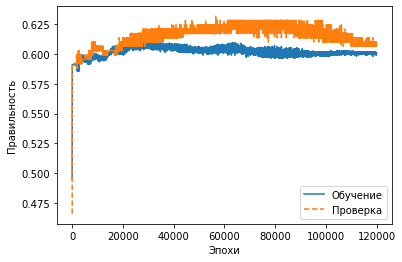

In [158]:
plt.plot(range(nn.epochs),nn.eval_['train_acc'],label = 'Обучение')
plt.plot(range(nn.epochs),nn.eval_['valid_acc'],label = 'Проверка', linestyle ='--')
plt.ylabel('Правильность')
plt.xlabel('Эпохи')
plt.legend(loc='lower right')
plt.show()